In [1]:
!pip install elasticsearch==7.12.0
!pip install arrow

In [20]:
!pip install nltk
!pip install seaborn
!pip install wordcloud

     |████████████████████████████████| 1.5 MB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 47.0 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 933 kB/s  eta 0:00:01
     |████████████████████████████████| 771 kB 38.9 MB/s eta 0:00:01
     |████████████████████████████████| 293 kB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 9.2 MB 51.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 40.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 84.0 MB/s eta 0:00:01
     |████████████████████████████████| 300 kB 57.1 MB/s eta 0:00:01
     |████████████████████████████████| 458 kB 5.5 MB/s eta 0:00:01


In [1]:
import os, arrow
from elasticsearch import Elasticsearch
from datetime import datetime
from config import SOC_ES_HOST,SOC_ES_USER, SOC_ES_PASSWORD, SOC_ES_PORT

import requests
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
import nltk

In [2]:
es = Elasticsearch([SOC_ES_HOST], http_auth=(SOC_ES_USER, SOC_ES_PASSWORD), port=SOC_ES_PORT, timeout=60)


In [3]:
res = es.search(index="streamfr", body={"query": {"match": { 
                'title':'covid',


            }
        }
    }
)
print("Got %d Hits:" % res['hits']['total']['value'])
for hit in res['hits']['hits']:
    #print("%(timestamp)s %(title)s: %(text)s" % hit["_source"])
    print(hit['_source'])

Got 10000 Hits:
{'edit_history_tweet_ids': [1634708775599845400], 'fixdate': '2023-03-12', 'fixhour': '2023-03-12-00', 'foundtime': 1678579918, 'text': '@POTUS Covid covid covid', 'author_id': 1560128340773769200, 'id': 1634708775599845400, 'annotation': '[{"domain": {"id": "10", "name": "Person", "description": "Named people in the world like Nelson Mandela"}, "entity": {"id": "10040395078", "name": "Joe Biden", "description": "US President Joe Biden"}}, {"domain": {"id": "35", "name": "Politician", "description": "Politicians in the world, like Joe Biden"}, "entity": {"id": "10040395078", "name": "Joe Biden", "description": "US President Joe Biden"}}, {"domain": {"id": "123", "name": "Ongoing News Story", "description": "Ongoing News Stories like \'Brexit\'"}, "entity": {"id": "1220701888179359745", "name": "COVID-19"}}, {"domain": {"id": "131", "name": "Unified Twitter Taxonomy", "description": "A taxonomy of user interests. "}, "entity": {"id": "10040395078", "name": "Joe Biden", "

In [32]:
def set_el_string(query:str) -> str:
     return "%s" %query.replace('|', 'OR')\
        .replace('/', '')\
        .replace('&', ' AND ')


index = 'streamfr'
query = 'title:Covid AND language:fr AND smitype:4'
data = []
doc = {"query": {"query_string": {"query": query, "default_operator": "AND"}},"size": 10000}



def get_news(index : str, keyword: dict , query=query, start = int(arrow.utcnow().shift(hours= -24).timestamp())
             ,end = int(arrow.utcnow().timestamp()),doc=doc):

    query = set_el_string(keyword['keywords']) + " AND timestamp:[{} TO {}]".format(start, end)
    print(query)
    if es.indices.exists(index=index):
            res = es.search(index = index,body= doc ,scroll="1m")

            while res['hits']['hits']:
                try:
                    sid = res['_scroll_id']
                    # get batch with data
                    scroll_res = res['hits']['hits']
                    data.extend(scroll_res)
                    # get next batch
                    res = es.scroll(scroll_id=sid, scroll="1m")
                except KeyError:
                    break
    else:
         return []
    return data


In [172]:
keywords = {}
keywords['keywords'] = 'covid' 
keywords = {'keywords': "id:100057438729357" }
data = get_news(query= query,keyword=keywords,index=index)

title:Covid AND language:fr AND smitype:4


In [42]:
import pandas as pd


keywords = {}
keywords['keywords'] = 'covid' 
keywords = {'keywords': "id:100057438729357" }

dataset = []
df = pd.DataFrame()
for i in range(6,7):
    
    query = "title:Covid AND language:fr AND smitype:4 AND fixdate:\"2023-03-%s\"" % str(i) 
    data = get_news(query= query,keyword=keywords,index=index)
    
    for item in data:
        dataset.append(item['_source'])

tmp = pd.DataFrame.from_dict(dataset)
df = df.append(tmp)


id:100057438729357 AND timestamp:[1681231170 TO 1681317570]


/tmp/ipykernel_22629/3769281792.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp)


<Axes: >

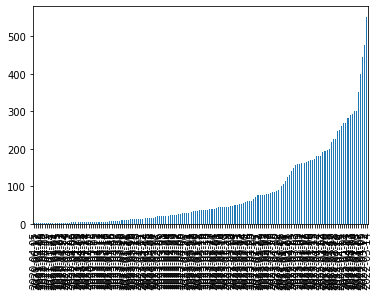

In [46]:
df['fixdate'].value_counts().sort_values().plot(kind= 'bar')
#df.my_column.value_counts().sort_values().plot(kind='bar')


In [44]:
df['fixdate'].describe()

count          12676
unique           160
top       2022-03-14
freq             552
Name: fixdate, dtype: object

In [11]:
len(df)

570420

In [63]:
import pandas as pd

keywords = {}
keywords['keywords'] = 'covid' 
keywords = {'keywords': "id:100057438729357" }


df = pd.DataFrame()
for i in range(1,32):
    
    query = 'title:Covid AND date:2023-04-'+str(i)
    data = get_news(query= query,keyword=keywords,index=index)
    

id:100057438729357 AND timestamp:[1681225030 TO 1681311430]


In [33]:
whole_article= ''
for i in range(len(data)):
    whole_article += str(data[i]['_source']['text'])

In [55]:
dates=[]

for i in range(len(data)):
    if not data[i]['_source']['date'] in dates:
        dates.append(data[i]['_source']['date']) 
    
print((dates))

['2023-02-19', '2022-02-25', '2022-04-21', '2023-03-01', '2022-04-19', '2022-04-07', '2022-03-12', '2023-03-08', '2022-03-06', '2022-03-05', '2023-01-21', '2022-03-11', '2023-02-15', '2023-02-13', '2023-01-19', '2023-01-03', '2023-01-02', '2023-01-04', '2023-03-11', '2023-02-09', '2023-01-30', '2022-03-30', '2023-02-22', '2023-01-25', '2022-04-05', '2022-03-10', '2022-04-26', '2022-04-20', '2022-03-15', '2022-03-13', '2022-03-14', '2022-03-20', '2022-04-24', '2022-04-23', '2022-03-03', '2022-03-27', '2023-02-17', '2023-01-20', '2023-02-01', '2020-03-23', '2023-03-21', '2022-04-06', '2022-04-25', '2022-03-28', '2022-03-07', '2022-02-24', '2022-02-23', '2022-02-26', '2022-04-18', '2023-01-13', '2023-01-12', '2022-02-28', '2022-02-20', '2022-03-22', '2022-03-04', '2023-02-06', '2023-02-03', '2023-03-14', '2023-03-13', '2020-11-03', '2023-02-20', '2022-04-22', '2023-01-24', '2023-02-27', '2023-02-28', '2023-03-02', '2022-03-21', '2022-03-02', '2022-02-19', '2023-02-16', '2023-02-25', '2023

In [64]:
len(data)

1056

In [34]:
type(data[2]['_source']['text'])
print(len(whole_article))

38379083


In [30]:
# Tokenize and remove unwanted words.

def preprocess_text(text):
    nltk.download('punkt')
    nltk.download('stopwords')
    tokens = word_tokenize(text.lower())
    french_stopwords = set(stopwords.words('french'))

    # Updated after first experiment, ask Yves if there are any words here that he doesn't want to remove
    missed_stopword_list = ['a','plus','cas','cette','depuis','contre','ans','après','fait', 'selon', 'aussi', 'moins', 'comme', 'être',
                         'si', 'tout', 'millions', 'très', 'faire', 'encore','dont','où', 'entre', 'avoir','autre','autres', 'sans', 'suite', 'alors'
                         , 'chez', 'déjà', 'ainsi', 'peu' , 'leurs']

    for missed_stopword in missed_stopword_list:
        french_stopwords.append(missed_stopword)
    unwanted_tokens = french_stopwords.union({"'", "’", "-", "»", "«"})
    filtered_tokens = [token for token in tokens if token not in unwanted_tokens and token.isalpha()]
    return filtered_tokens

def count_words(tokens):
    return Counter(tokens)


# to remove html tags
def extract_text(articles):
    ''' input: List of article
        returns:
            whole text without html tags
    '''
    text = ""
    for article in articles:
        soup = BeautifulSoup(article, 'html.parser')
        text += soup.get_text()
    return text

def extract_text_from_single_article(article):
    '''
    input : 
            Single article
    returns :  
            Text version of article without html tags
    '''
    soup = BeautifulSoup(article, 'html.parser')
    return soup.get_text()




In [39]:
print(stopwords.words('french'))

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

In [37]:
tmp = preprocess_text(extract_text_from_single_article(whole_article))

In [36]:
counted_words = count_words(tmp)

sorted_counted_words = sorted(counted_words.items(), key=lambda x: x[1], reverse=True)
print(sorted_counted_words)

[('a', 31419), ('plus', 19065), ('cas', 14932), ('personnes', 8078), ('cette', 7582), ('santé', 7390), ('covid', 7113), ('depuis', 6313), ('mars', 6225), ('contre', 5822), ('pays', 5679), ('ans', 5217), ('france', 5167), ('après', 5032), ('fait', 4944), ('nombre', 4920), ('deux', 4840), ('chine', 4757), ('pandémie', 4631), ('selon', 4417), ('aussi', 4365), ('moins', 4320), ('comme', 4247), ('sanitaire', 4163), ('virus', 4161), ('situation', 4130), ('être', 3992), ('jours', 3860), ('masque', 3793), ('décès', 3718), ('fin', 3672), ('si', 3646), ('vaccin', 3610), ('tout', 3496), ('millions', 3426), ('début', 3403), ('vaccination', 3376), ('lundi', 3354), ('très', 3348), ('mois', 3324), ('février', 3294), ('faire', 3155), ('encore', 3154), ('lire', 3134), ('patients', 3125), ('monde', 3114), ('semaine', 3092), ('taux', 3041), ('dose', 3039), ('population', 2980), ('avril', 2856), ('dont', 2852), ('où', 2848), ('janvier', 2796), ('nouveaux', 2781), ('mesures', 2766), ('jour', 2755), ('entre

In [38]:
def filter_keywords(word_counts, threshold):
    return {word: count for word, count in word_counts.items() if count >= threshold}
threshold = np.percentile(list(counted_words.values()), 95)
important_keywords = filter_keywords(counted_words, threshold)

# Sort important keywords

sorted_important_keywords = sorted(important_keywords.items(), key = lambda x: x[1], reverse= True)

# Print results

print(sorted_important_keywords)

print('Number of all words:', str(len(sorted_counted_words)))
print('Number of important keywords words:', str(len(sorted_important_keywords)))

[('a', 31419), ('plus', 19065), ('cas', 14932), ('personnes', 8078), ('cette', 7582), ('santé', 7390), ('covid', 7113), ('depuis', 6313), ('mars', 6225), ('contre', 5822), ('pays', 5679), ('ans', 5217), ('france', 5167), ('après', 5032), ('fait', 4944), ('nombre', 4920), ('deux', 4840), ('chine', 4757), ('pandémie', 4631), ('selon', 4417), ('aussi', 4365), ('moins', 4320), ('comme', 4247), ('sanitaire', 4163), ('virus', 4161), ('situation', 4130), ('être', 3992), ('jours', 3860), ('masque', 3793), ('décès', 3718), ('fin', 3672), ('si', 3646), ('vaccin', 3610), ('tout', 3496), ('millions', 3426), ('début', 3403), ('vaccination', 3376), ('lundi', 3354), ('très', 3348), ('mois', 3324), ('février', 3294), ('faire', 3155), ('encore', 3154), ('lire', 3134), ('patients', 3125), ('monde', 3114), ('semaine', 3092), ('taux', 3041), ('dose', 3039), ('population', 2980), ('avril', 2856), ('dont', 2852), ('où', 2848), ('janvier', 2796), ('nouveaux', 2781), ('mesures', 2766), ('jour', 2755), ('entre

In [43]:
counted_words = count_words(tmp)

sorted_counted_words = sorted(counted_words.items(), key=lambda x: x[1], reverse=True)
print(sorted_counted_words)

[('pandémie', 11), ('plus', 11), ('a', 9), ('alimentaire', 9), ('canadiens', 9), ('comme', 7), ('consommateurs', 6), ('nouvelles', 5), ('ailleurs', 5), ('plusieurs', 4), ('laboratoire', 4), ('sciences', 4), ('analytiques', 4), ('agroalimentaire', 4), ('université', 4), ('dalhousie', 4), ('industrie', 4), ('depuis', 4), ('sial', 4), ('ici', 4), ('maison', 4), ('moins', 4), ('nombre', 4), ('animal', 4), ('magasinent', 3), ('régulière', 3), ('changé', 3), ('nourriture', 3), ('cette', 3), ('grand', 3), ('fois', 3), ('tendances', 3), ('marché', 3), ('canada', 3), ('gens', 3), ('temps', 3), ('alimentation', 3), ('début', 3), ('faire', 3), ('avant', 3), ('compagnie', 3), ('ménages', 3), ('considèrent', 3), ('alimentaires', 3), ('ligne', 3), ('legs', 2), ('avoir', 2), ('incité', 2), ('reconsidérer', 2), ('endroit', 2), ('où', 2), ('achètent', 2), ('leurs', 2), ('aliments', 2), ('base', 2), ('monde', 2), ('relation', 2), ('semaine', 2), ('montréal', 2), ('salon', 2), ('innovation', 2), ('amériq

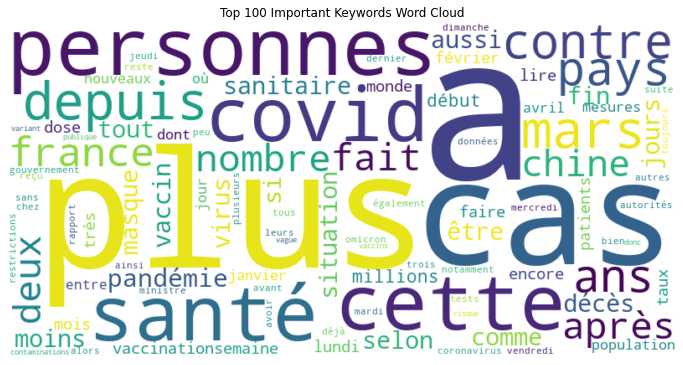

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(word_counts, title, n_keywords=100):
    top_n_keywords = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:n_keywords])

    plt.figure(figsize=(12, 8))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_n_keywords)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Plot the word cloud for the top 100 important keywords
plot_word_cloud(important_keywords, "Top 100 Important Keywords Word Cloud", n_keywords=100)


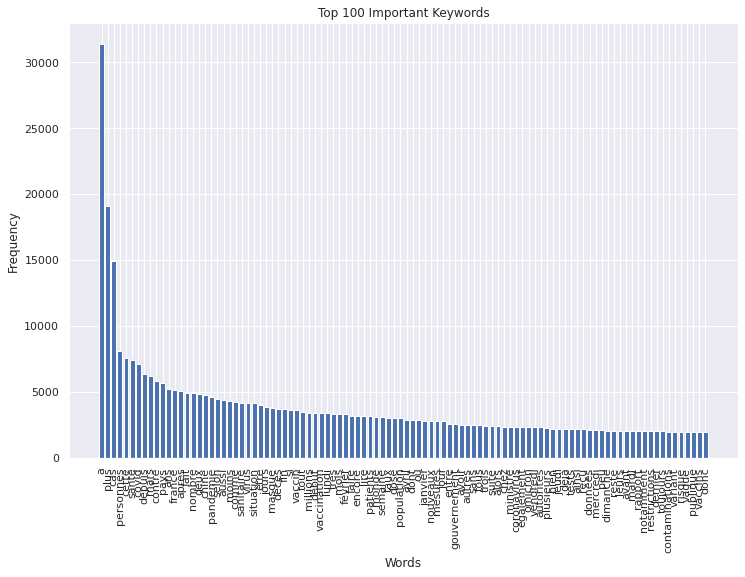

In [28]:
def plot_word_frequencies(word_counts, title, n_keywords=100):
    sns.set(style="darkgrid")
    plt.figure(figsize=(12, 8))

    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:n_keywords]
    words, counts = zip(*sorted_word_counts)

    plt.bar(words, counts)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

# Plot the bar chart for the top 100 important keywords
plot_word_frequencies(important_keywords, "Top 100 Important Keywords", n_keywords=100)
